# Copper Energy Demands
This journal documents the energy demands of mining, refining, drawing and recycling of copper for use inside the PV cell. Probably also applies to copper in wiring (not yet considered)

In [1]:
import numpy as np
import pandas as pd
import os,sys
from pathlib import Path
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (8, 4)
cwd = os.getcwd() #grabs current working directory

supportMatfolder = str(Path().resolve().parent.parent.parent / 'PV_ICE' / 'baselines' / 'SupportingMaterial')
baselinesFolder = str(Path().resolve().parent.parent.parent / 'PV_ICE' / 'baselines')

### Mining Energy

In [2]:
cu_mining_raw = pd.read_csv(os.path.join(supportMatfolder+"\energy-input-copper-mining.csv"), index_col='year')
cu_mining_raw.dropna(how='all')

,E_CuMining_kWhpkg,PrctFuel,Source,Notes
year,,,,
1975,15.947000,NaN,"Bravard, J. C., H. B. Flora, and Charles Porta...",mining and milling and flotation of 0.3% Cu or...
2001,1.319000,90.74%,"Lagos, Gustavo, David Peters, Alvaro Videla, a...","Table 1, open pit mine, likely includes transp..."
2002,0.611000,43.18%,"Lagos, Gustavo, David Peters, Alvaro Videla, a...","Table 1, underground mine, likely includes tra..."
2009,0.006000,NaN,"Bleiwas, Donald. 2011. “Estimates of Electrici...","Table 13, processed ore instead of tonne coppe..."
2010,11.110800,NaN,"Norgate, Terry, and Sharif Jahanshahi. 2011. “...","Cu Mining and mineral processing HYDRO, embodi..."
2011,18.055050,NaN,"Norgate, Terry, and Sharif Jahanshahi. 2011. “...","Cu Mining and mineral processing PYRO, emboied E"
2013,3.499902,NaN,"Elshkaki, Ayman, T. E. Graedel, Luca Ciacci, a...","range of 30-90 for ""primary production"", which..."
2014,2.244400,92.57%,"Lagos, Gustavo, David Peters, Alvaro Videla, a...","Table 1, open pit mine, likely includes transp..."
2015,1.097200,43.54%,"Lagos, Gustavo, David Peters, Alvaro Videla, a...","Table 1, underground mine, likely includes tra..."


Text(0, 0.5, 'kWh/kg')

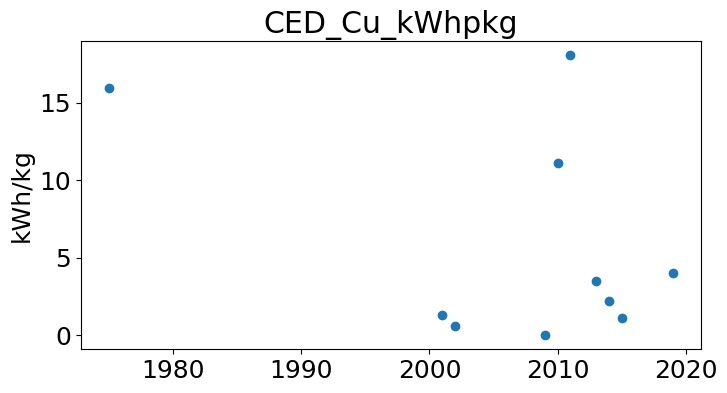

In [3]:
plt.scatter(cu_mining_raw.index, cu_mining_raw['E_CuMining_kWhpkg'], marker='o')
plt.title('CED_Cu_kWhpkg')
plt.ylabel('kWh/kg')

In [4]:
#drop ones that include more than just mining and concentration.
cu_mining_raw.loc[1975] = np.nan
cu_mining_raw.loc[2010] = np.nan
cu_mining_raw.loc[2011] = np.nan


Text(0, 0.5, 'kWh/kg')

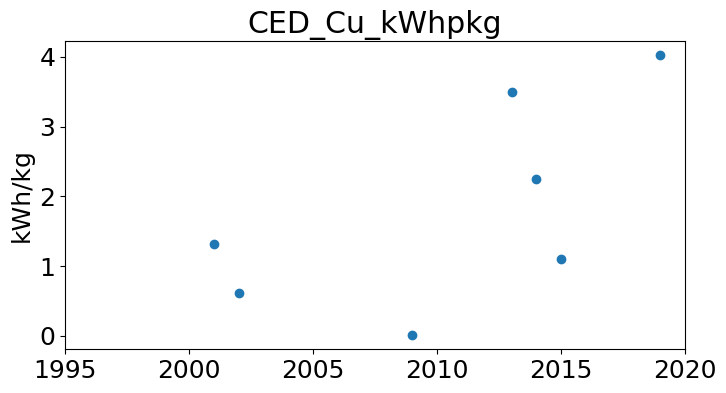

In [5]:
plt.scatter(cu_mining_raw.index, cu_mining_raw['E_CuMining_kWhpkg'], marker='o')
plt.xlim(1995,2020)
plt.title('CED_Cu_kWhpkg')
plt.ylabel('kWh/kg')

This is a scatter plot. We're going to use Farjana et al 2019 because of the detail provided in the datapoint. 

### CED
CED would include mining, so we might subtract the mining energy from the final CED trend.

In [6]:
cu_CED_raw = pd.read_csv(os.path.join(supportMatfolder+"\energy-input-copper-CED.csv"), index_col='year')
cu_CED_raw.dropna(how='all')

,CED_Cu_kWhpkg,PrctFuel,Source,Notes
year,,,,
1995,25.000000,NaN,"G. J. M. Phylipsen and E. A. Alsema, “Environm...","gross energy requirement cathodic copper, van ..."
1998,11.705984,49.0,"Alvarado, S. 2002. “Long Term Energy-Related E...","Table 4, data source apparently COCHILCO, only..."
1999,0.294000,NaN,"R. U. Ayres, L. W. Ayres, and I. Råde, The Lif...","Chilean Cu Smelters, average"
2000,9.166700,NaN,"Rankin, John. 2012. “Energy Use in Metal Produ...","embodied energy, pyro, from Norgate and Rankin..."
2001,17.917000,NaN,"Rankin, John. 2012. “Energy Use in Metal Produ...","embodied energy, hydro, from Norgate and Ranki..."
2003,16.667000,NaN,"R. U. Ayres, L. W. Ayres, and I. Råde, The Lif...","avg ore grade (>0.1% grade), OECD"
2005,14.900000,20.0,"Marsden, John O. “Energy Efficiency & Copper H...","Slide 33+35, 35% SX/EW hydro 65% Concentrate p..."
2006,17.777000,NaN,"Norgate, T. E., S. Jahanshahi, and W. J. Ranki...","GER, cradle to gate, heap leaching and SX/EW p..."
2007,9.166000,NaN,"Norgate, T. E., S. Jahanshahi, and W. J. Ranki...","GER, cradle to gate of mfg, includes Smelting/..."


Text(0, 0.5, 'kWh/kg')

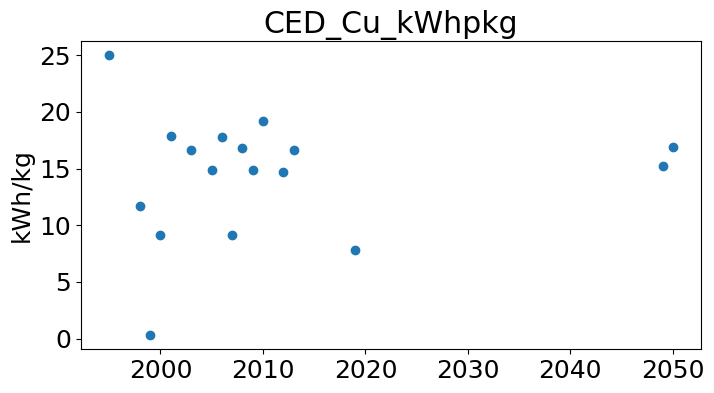

In [7]:
plt.scatter(cu_CED_raw.index, cu_CED_raw['CED_Cu_kWhpkg'], marker='o')
plt.title('CED_Cu_kWhpkg')
plt.ylabel('kWh/kg')

In [8]:
#drop the low outlier
cu_CED_raw.loc[1999] = np.nan
#drop the 2009 Nuss datapoint because it includes recycled content
cu_CED_raw.loc[2009] = np.nan
#drop 2012 EU survey, includes scrap content
cu_CED_raw.loc[2012] = np.nan

The remaining lower energy points are associated with the difference between Hydro and Pyro metallurgy. 

In [9]:
cu_CED_raw.loc[2000:2001,['Notes']]

,Notes
year,
2000,"embodied energy, pyro, from Norgate and Rankin..."
2001,"embodied energy, hydro, from Norgate and Ranki..."


In [10]:
cu_CED_raw.loc[2006:2007,['Notes']]

,Notes
year,
2006,"GER, cradle to gate, heap leaching and SX/EW p..."
2007,"GER, cradle to gate of mfg, includes Smelting/..."


In [11]:
#find pyro data
cu_CED_trim = cu_CED_raw.dropna(how='all')
cu_CED_trim_pyro = cu_CED_trim[cu_CED_trim['Notes'].str.contains('pyro')]
cu_CED_trim_pyro#.index

,CED_Cu_kWhpkg,PrctFuel,Source,Notes
year,,,,
1998,11.705984,49.0,"Alvarado, S. 2002. “Long Term Energy-Related E...","Table 4, data source apparently COCHILCO, only..."
2000,9.166700,NaN,"Rankin, John. 2012. “Energy Use in Metal Produ...","embodied energy, pyro, from Norgate and Rankin..."
2005,14.900000,20.0,"Marsden, John O. “Energy Efficiency & Copper H...","Slide 33+35, 35% SX/EW hydro 65% Concentrate p..."
2007,9.166000,NaN,"Norgate, T. E., S. Jahanshahi, and W. J. Ranki...","GER, cradle to gate of mfg, includes Smelting/..."
2010,19.167000,NaN,"Rötzer, Nadine, and Mario Schmidt. 2020. “Hist...","CED for Cu anodes (not wire), pyrometallurgy f..."
2050,16.900000,NaN,"Rötzer, Nadine, and Mario Schmidt. 2020. “Hist...","copper cathode, assumes 0.5% ore grade and 100..."


In [12]:
#find hydro data
cu_CED_trim_hydro = cu_CED_trim[cu_CED_trim['Notes'].str.contains('hydro')]
cu_CED_trim_hydro#.index

,CED_Cu_kWhpkg,PrctFuel,Source,Notes
year,,,,
2001,17.917,NaN,"Rankin, John. 2012. “Energy Use in Metal Produ...","embodied energy, hydro, from Norgate and Ranki..."
2005,14.900,20.0,"Marsden, John O. “Energy Efficiency & Copper H...","Slide 33+35, 35% SX/EW hydro 65% Concentrate p..."
2006,17.777,NaN,"Norgate, T. E., S. Jahanshahi, and W. J. Ranki...","GER, cradle to gate, heap leaching and SX/EW p..."


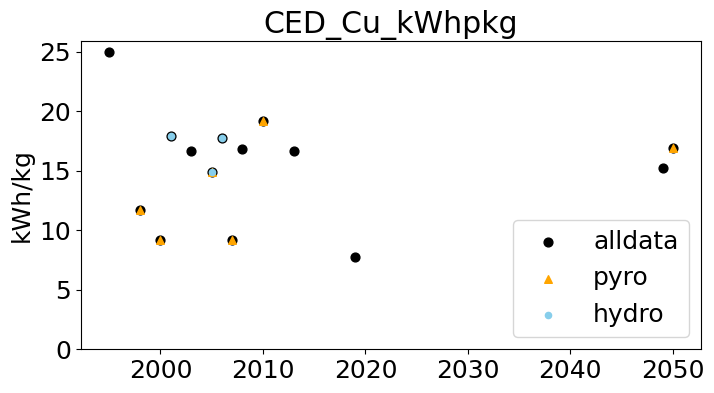

In [13]:
plt.scatter(cu_CED_raw.index, cu_CED_raw['CED_Cu_kWhpkg'], marker='o', label='alldata', color='black', s=40)
plt.scatter(cu_CED_trim_pyro.index, cu_CED_trim_pyro['CED_Cu_kWhpkg'], marker='^', label='pyro', color='orange', s=30)
plt.scatter(cu_CED_trim_hydro.index, cu_CED_trim_hydro['CED_Cu_kWhpkg'], marker='o', label='hydro', color='skyblue', s=20)

plt.ylim(0,)
plt.title('CED_Cu_kWhpkg')
plt.ylabel('kWh/kg')
plt.legend()

Our method will be to take the average of the hydro and average of the pyro CEDs, then use marketshare of each technology over time for 1995 through 2050. Then we will use the projected energy from Rotzer for 2050 and interpolate. This neglects the detail of increasing energy demands for decreasing ore grade - however, the correlation from Northey is <0.4 for the full process and average global ore grade over time has been hard to find and is not fully representative of energy demands.

In [14]:
#hydro
CED_hydro = cu_CED_trim_hydro['CED_Cu_kWhpkg'].mean()

In [15]:
#pyro
cu_CED_trim_pyro.loc[2050]=np.nan #drop the 2050 value (will use to interpolate later)
CED_pyro = cu_CED_trim_pyro['CED_Cu_kWhpkg'].mean()
CED_pyro

12.821136808

In [16]:
#import marketshare
mrktshr_pyrohydro_raw = pd.read_excel(os.path.join(supportMatfolder+"\energy-inputs-copper-maths.xlsx"),
              sheet_name='pyrovshydro', index_col=0, header=[0])

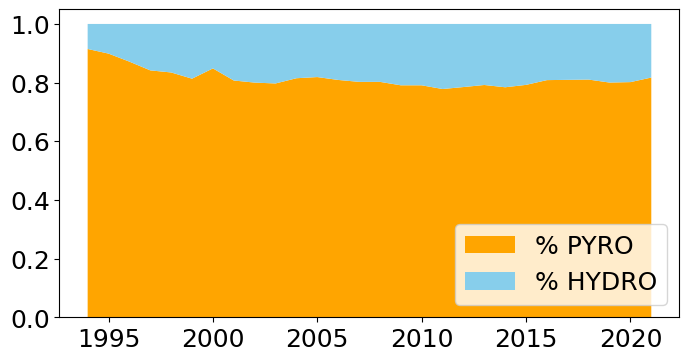

In [17]:
mrktshr_pyrohydro = mrktshr_pyrohydro_raw[['% PYRO','% HYDRO']]

plt.stackplot(mrktshr_pyrohydro.index, mrktshr_pyrohydro['% PYRO'], mrktshr_pyrohydro['% HYDRO'], colors=['orange','skyblue'])
plt.legend(mrktshr_pyrohydro.columns, loc='lower right')

In [18]:
pyro_mrktshr_CED = mrktshr_pyrohydro['% PYRO']*CED_pyro
pyro_mrktshr_CED[0:5]

“The World Copper Factbook 2022.” 2022, 68.
1994    11.727135
1995    11.524796
1996    11.173422
1997    10.791721
1998    10.700371
Name: % PYRO, dtype: float64

In [19]:
hydro_mrktshr_CED = mrktshr_pyrohydro['% HYDRO']*CED_hydro
hydro_mrktshr_CED[0:5]

“The World Copper Factbook 2022.” 2022, 68.
1994    1.439028
1995    1.705181
1996    2.167372
1997    2.669453
1998    2.789612
Name: % HYDRO, dtype: float64

In [20]:
11.727135+1.439028

13.166163000000001

(10.0, 20.0)

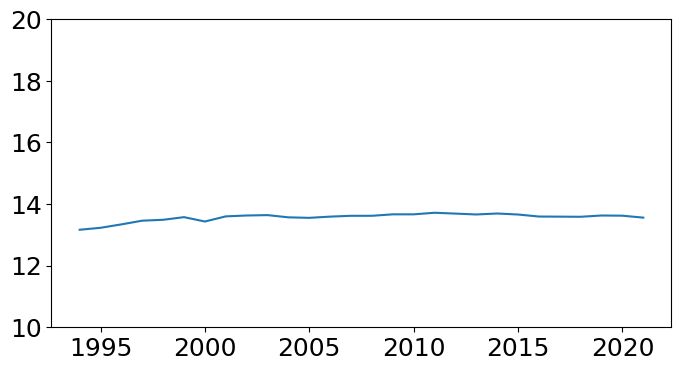

In [21]:
CED_mrktshr = pd.DataFrame(pyro_mrktshr_CED+hydro_mrktshr_CED)
plt.plot(CED_mrktshr)
plt.ylim(10,20)

Now in 2050 we have two projections of energy demand in 2050. There is another projection from Elshkaki 2016, but this is older and nearly double the other two estimates. We will average the two 2050 projection estimates and interpolate to that value.

In [22]:
CED_Cu_tofill = pd.concat([CED_mrktshr.loc[1995:],cu_CED_raw.loc[2022:,'CED_Cu_kWhpkg']])
#create the new 2050 value
CED_2050_mean = cu_CED_raw.loc[2022:,'CED_Cu_kWhpkg'].dropna(how='all').mean()
#CED_2050_mean
#set the 2049 to nan and 2050 to the new mean
CED_Cu_tofill.loc[2049]=np.nan
CED_Cu_tofill.loc[2050]=CED_2050_mean
#interpolate
CED_Cu_filled = CED_Cu_tofill.interpolate()

(10.0, 20.0)

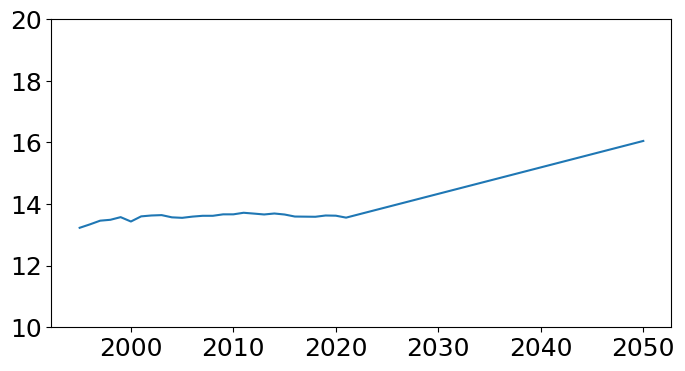

In [24]:
plt.plot(CED_Cu_filled)
plt.ylim(10,20)

### Add the Energy to turn Cu cathode in to Cu wire

In [25]:
cu_wireDraw_raw = pd.read_csv(os.path.join(supportMatfolder+"\energy-input-copper-wireDraw.csv"), index_col='year')
cu_wireDraw_raw.dropna(how='all')

,E_wireDraw_kWhpkg,PrctFuel,Source,Notes
year,,,,
1995,2.778000,NaN,"G. J. M. Phylipsen and E. A. Alsema, “Environm...","Estimate, 18 GJ/ton to melt Cu, only need to s..."
2010,0.230944,NaN,"Bumby, Sarah, Ekaterina Druzhinina, Rebe Feral...","LCA of grid distribution system, Supplemental ..."
2012,14.698514,NaN,“The Environmental Profile of Copper Products ...,"PED from LCA from EU copper institute, include..."
2018,0.169952,NaN,"Rodriguez-Alabanda, O., P. E. Romero, G. Guerr...",are selling a software optimizing wire pulling...
2021,2.160795,NaN,"Yu, Huiling, Hao Sun, Weixia Liu, Ruiqiu Zhang...",Table 1 updrawing casting machine + big drawin...


In [44]:
#subtract the average historical CED of Cu from the 2012 data to get just wire pulling part
adj_wire = cu_wireDraw_raw.loc[2012,'E_wireDraw_kWhpkg']-CED_mrktshr.mean() #using the historical with marketshare hydro/pyro wtd
cu_wireDraw_raw.loc[2012,'E_wireDraw_kWhpkg'] = adj_wire[0]
adj_wire

0    1.131648
dtype: float64

In [45]:
cu_wireDraw_raw.dropna(how='all')

,E_wireDraw_kWhpkg,PrctFuel,Source,Notes
year,,,,
1995,2.778000,NaN,"G. J. M. Phylipsen and E. A. Alsema, “Environm...","Estimate, 18 GJ/ton to melt Cu, only need to s..."
2010,0.230944,NaN,"Bumby, Sarah, Ekaterina Druzhinina, Rebe Feral...","LCA of grid distribution system, Supplemental ..."
2012,1.131648,NaN,“The Environmental Profile of Copper Products ...,"PED from LCA from EU copper institute, include..."
2018,0.169952,NaN,"Rodriguez-Alabanda, O., P. E. Romero, G. Guerr...",are selling a software optimizing wire pulling...
2021,2.160795,NaN,"Yu, Huiling, Hao Sun, Weixia Liu, Ruiqiu Zhang...",Table 1 updrawing casting machine + big drawin...


None of these are very large. We will average these values to estimate the wire drawing requirements, then add it to the CED to get a MFGing of virgin Cu. This value will also be added to the recycling processing requirements below.

In [48]:
e_wireDraw = cu_wireDraw_raw['E_wireDraw_kWhpkg'].mean()
e_wireDraw

1.2942678788092012

In [55]:
CED_Cu_virgin = round(CED_Cu_filled+e_wireDraw,2)
CED_Cu_virgin.to_csv(os.path.join(supportMatfolder+'\output_energy_Cu_Mfging.csv'))

# Cu Recycling